In [1]:
# Import dependencies
import pandas as pd
import sqlite3
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import tensorflow as tf
import pickle
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:

# Connect to the SQLite database
conn = sqlite3.connect("../Resources/fetal_health_CTG_data.db")

# Query to select all data from the table
query = "SELECT * FROM fetal_health_CTG_data"

# Read data from the database into a DataFrame
fetal_df= pd.read_sql_query(query, conn)

# Close the connection
conn.close()




In [3]:
# Display the DataFrame
fetal_df.head()

,baseline_FHR_bpm,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolonged_decelerations,abnorm_ST_Var_Perc,mean_ST_Var,abnorm_LT_Var_Perc,...,FHR_hist_min,FHR_hist_max,FHR_hist_num_peaks,FHR_hist_num_zeroes,FHR_hist_mode,FHR_hist_mean,FHR_hist_median,FHR_hist_variance,FHR_hist_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1


In [4]:
#check the value counts of fetal health
health_status_ct=fetal_df["fetal_health"].value_counts()
health_status_ct

fetal_health
1    1655
2     295
3     176
Name: count, dtype: int64

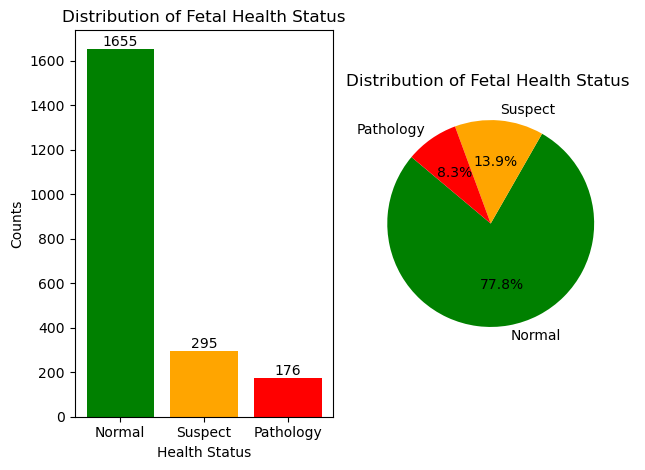

In [5]:
# Create barplot
labels = ["Normal", "Suspect", "Pathology"]
#colors = {"Normal": "green", "Suspect": "orange", "Pathology": "red"}

plt.plot

plt.bar(labels, health_status_ct, color=[colors[label] for label in labels])
plt.xlabel("Health Status")
plt.ylabel("Counts")
plt.title("Distribution of Fetal Health Status")

# Add count labels on top of each bar
for i, count in enumerate(health_status_ct):
    plt.text(i, count, str(count), ha="center", va="bottom")

# Subplot for pie chart
plt.subplot(1, 2, 2)
plt.pie(health_status_ct, labels=labels, autopct="%1.1f%%", startangle=140,colors=[colors[label] for label in labels])
plt.title("Distribution of Fetal Health Status ")

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


## Machine Learning Model

Create the labels set (y) from the “fetal_health” column
and then create the features (X) DataFrame from the remaining columns.

In [6]:
# Separate the data into labels and features
# Separate the y variable, the labels
target=fetal_df["fetal_health"]

# Separate the X variable, the features
data = fetal_df.drop("fetal_health",axis=1)
features_df=data.columns


In [7]:
#check the label and features
print(target)
print(features_df)

0       2
1       1
2       1
3       1
4       1
       ..
2121    2
2122    2
2123    2
2124    2
2125    1
Name: fetal_health, Length: 2126, dtype: int64
Index(['baseline_FHR_bpm', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolonged_decelerations', 'abnorm_ST_Var_Perc', 'mean_ST_Var',
       'abnorm_LT_Var_Perc', 'mean_LT_Var', 'FHR_hist_width', 'FHR_hist_min',
       'FHR_hist_max', 'FHR_hist_num_peaks', 'FHR_hist_num_zeroes',
       'FHR_hist_mode', 'FHR_hist_mean', 'FHR_hist_median',
       'FHR_hist_variance', 'FHR_hist_tendency'],
      dtype='object')


In [8]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=48)

In [9]:
#value of count of training dataset
#X_train.shape
train_data=pd.Series(y_train).value_counts()
train_data

fetal_health
1    1245
2     220
3     129
Name: count, dtype: int64

In [10]:
#value of count of testing dataset
#x_test.shape()
test_data=pd.Series(y_test).value_counts()
test_data

fetal_health
1    410
2     75
3     47
Name: count, dtype: int64

## Random Oversampling technique to balance the class distribution.

In [11]:
#instantiate the random_oversampler 
Sampler = RandomOverSampler(random_state=48)
X_sample, y_sample = Sampler.fit_resample(X_train,y_train)

# Fit the original training data to the random_oversampler 
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_sample, y_sample, random_state=48)

In [12]:
#value of count of training dataset after ros
#X_train.shape
train_data_ros=pd.Series(y_train_ros).value_counts()
train_data_ros=train_data_ros.sort_index()
train_data_ros

fetal_health
1    922
2    932
3    947
Name: count, dtype: int64

In [13]:
#value of count of testing dataset after ros
#x_test.shape()
test_data_ros=pd.Series(y_test_ros).value_counts()
test_data_ros

fetal_health
1    323
2    313
3    298
Name: count, dtype: int64

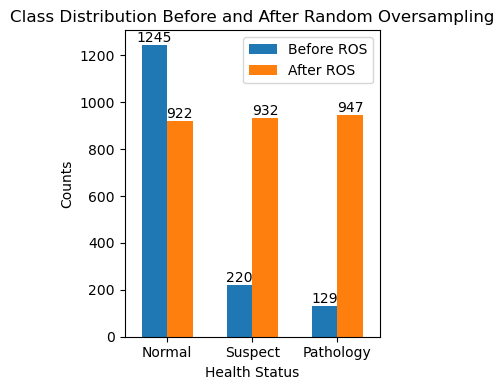

In [14]:
#set the labels
labels = ["Normal", "Suspect", "Pathology"]

# Generate evenly spaced x positions for the bars
x = np.arange(len(labels))

# Define the width of the bars
width = 0.30

   
fig, ax = plt.subplots(figsize=(3.5,4)) 


# Plot the bars for the original data
rects1 = ax.bar(x - width/2, train_data, width, label="Before ROS")

# Plot the bars for the oversampled data
rects2 = ax.bar(x + width/2, train_data_ros, width, label="After ROS")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Health Status")
ax.set_ylabel("Counts")
ax.set_title("Class Distribution Before and After Random Oversampling")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add counts on top of each bar using enumerate
for i, rect in enumerate(rects1 + rects2):
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0,0.03),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')



# Set the x-axis limits to reduce the spacing between the categories
ax.set_xlim(-0.5, len(labels)-0.5)
# Display the plot
plt.tight_layout()
plt.show()

## Random Forest 


In [15]:
#create Random Forest classifier
rf = RandomForestClassifier(random_state=48)

# Train the classifier
#rf.fit(X_train_ros, y_train_ros)

In [16]:
# Define the hyperparameters grid for GridSearchCV
param_grid = {
    "n_estimators": [50, 200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    
}

In [17]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_ros, y_train_ros)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=48),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 200, 500]})

In [18]:
# Get the best parameters and the best model
best_rf_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print(best_rf_params)
print(best_rf_model)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
RandomForestClassifier(max_depth=20, n_estimators=500, random_state=48)


In [19]:
#Make predictions on the test set
#predictions_rf = rf.predict(X_test_ros)

# Make predictions,Evaluate the best model on the test set
predictions_rf = best_rf_model.predict(X_test_ros)

In [20]:
# Calculate accuracy
accuracy_rf = accuracy_score(y_test_ros, predictions_rf)
print("Accuracy_RF:", accuracy_rf)

Accuracy_RF: 0.9850107066381156


In [21]:
# Assuming rf is your trained RandomForestClassifier model
predictions_train_rf =  best_rf_model.predict(X_train_ros)


In [23]:
# Calculate  train accuracy
accuracy_rf_train = accuracy_score(y_train_ros, predictions_train_rf)
print("Accuracy_RF:", accuracy_rf_train)

Accuracy_RF: 0.9996429846483399


In [24]:
#Generate confusion matrix
cm=confusion_matrix(y_test_ros, predictions_rf)
cm_df_rf=pd.DataFrame(cm,index=["Normal(A)","Suspect(A)","pathology(A)"],columns=["Normal(P)","Suspect(p)","pathology(p)"])
print("Random Forest Confusion Matix")
cm_df_rf

Random Forest Confusion Matix


,Normal(P),Suspect(p),pathology(p)
Normal(A),309,11,3
Suspect(A),0,313,0
pathology(A),0,0,298


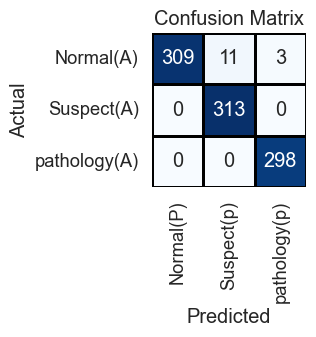

In [25]:

# Set font scale
sns.set(font_scale=1.2)

# Plot the confusion matrix
plt.figure(figsize=(2,2))
sns.heatmap(cm_df_rf, annot=True, fmt="d", cmap="Blues", cbar=False, square=True, linewidths=2, linecolor="black")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [26]:
# print the classification report
print(" Random Forest using random over sampler")
rf_report=classification_report(y_test_ros, predictions_rf)
print(rf_report)

 Random Forest using random over sampler
              precision    recall  f1-score   support

           1       1.00      0.96      0.98       323
           2       0.97      1.00      0.98       313
           3       0.99      1.00      0.99       298

    accuracy                           0.99       934
   macro avg       0.99      0.99      0.99       934
weighted avg       0.99      0.99      0.98       934



Results:
|   Class   | Precision | Recall | F1-score | Support |
|-----------|-----------|--------|----------|---------|
|  Normal   |    1.00   |  0.96  |   0.98   |   323   |
|  Suspect  |    0.97   |  1.00  |   0.98   |   313   |
| Pathology |    0.99   |  1.00  |   0.99   |   298   |


In [27]:
# Random Forests in sklearn will automatically calculate feature importance
importances =best_rf_model.feature_importances_

# We can sort the features by their importance
importances_sorted=sorted(zip(best_rf_model.feature_importances_,data.columns), reverse=True)
print("Top 10 important features")
importances_sorted[:10]

Top 10 important features


[(0.14571629886051352, 'abnorm_ST_Var_Perc'),
 (0.13529423836055937, 'abnorm_LT_Var_Perc'),
 (0.10123729178334634, 'FHR_hist_mean'),
 (0.08874157946775178, 'FHR_hist_median'),
 (0.06993374089903015, 'mean_ST_Var'),
 (0.06905482006644251, 'accelerations'),
 (0.056786199592387246, 'FHR_hist_mode'),
 (0.051640730529898204, 'mean_LT_Var'),
 (0.04310995222309031, 'baseline_FHR_bpm'),
 (0.03697563706398269, 'prolonged_decelerations')]

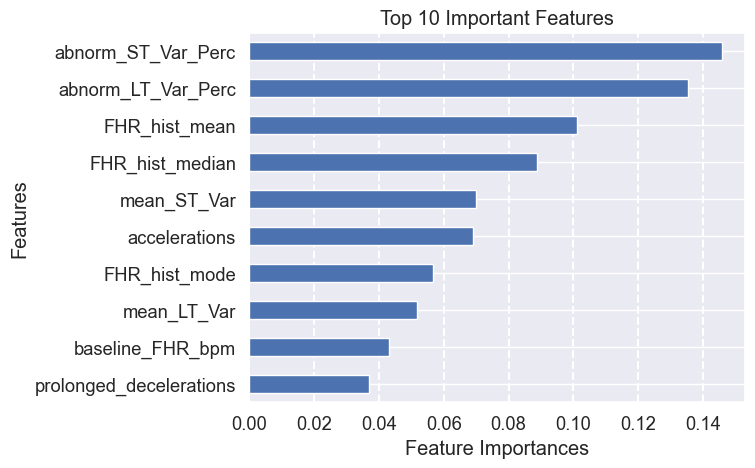

In [28]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(best_rf_model.feature_importances_, data.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: "Feature Importances"}, inplace=True)
importances_sorted = importances_df.sort_values(by="Feature Importances")

# Selecting only the top 10 important features
top_10_importances = importances_sorted.tail(10)

# Plotting the top 10 important features
top_10_importances.plot(kind="barh",title="Top 10 Important Features", legend=False)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
# Adding grid lines
plt.grid(True, axis="x", linestyle="--", linewidth=1.5)
plt.show()


## Gradient Boosting Classifier


In [29]:
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=48)

In [30]:
# Train the classifier on the training data
#gb_classifier.fit(X_train_ros, y_train_ros)
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}


In [31]:
# Initialize GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)



In [32]:
# Fit the grid search to the data
grid_search_gb.fit(X_train_ros, y_train_ros)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=48),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [33]:
# Get the best parameters and the best model
best_gb_params = grid_search_gb.best_params_
best_gb_model = grid_search_gb.best_estimator_
print("Best Parameters:", best_gb_params)
print("Best Model:", best_gb_model)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best Model: GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=200,
                           random_state=48)


In [34]:
# Make predictions on the testing data
#predictions_gb = gb_classifier.predict(X_test_ros)
# Make predictions,Evaluate the best model on the test set
predictions_gb = best_gb_model.predict(X_test_ros)

In [35]:
# Calculate accuracy
accuracy_gb = accuracy_score(y_test_ros, predictions_gb)
print("Accuracy_gb:", accuracy_gb)


Accuracy_gb: 0.9935760171306209


In [36]:
# Assuming rf is your trained RandomForestClassifier model
predictions_train_gb = best_gb_model.predict(X_train_ros)


In [38]:
# Calculate  train accuracy
accuracy_gb_train = accuracy_score(y_train_ros, predictions_train_gb)
print("Accuracy_RF:", accuracy_gb_train)

Accuracy_RF: 0.9996429846483399


In [39]:
# Generate a confusion matrix
cm = confusion_matrix(y_test_ros, predictions_gb)
print("Confusion Matrix:")
cm_df_gb=pd.DataFrame(cm,index=["Normal(A)","Suspect(A)","pathology(A)"],columns=["Normal(P)","Suspect(p)","pathology(p)"])
print("Gradient Boosting Classifier")

cm_df_gb

Confusion Matrix:
Gradient Boosting Classifier


,Normal(P),Suspect(p),pathology(p)
Normal(A),317,6,0
Suspect(A),0,313,0
pathology(A),0,0,298


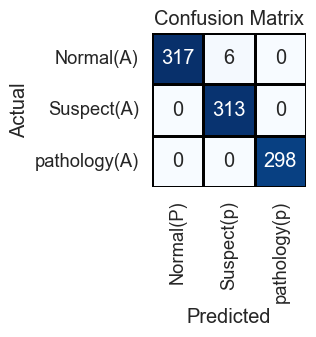

In [40]:

# Set font scale
sns.set(font_scale=1.2)

# Plot the confusion matrix
plt.figure(figsize=(2,2))
sns.heatmap(cm_df_gb, annot=True, fmt="d", cmap="Blues", cbar=False, square=True, linewidths=2, linecolor="black")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [41]:
# Generate a classification report
print("GB Classification Report :")
gb_report=classification_report(y_test_ros, predictions_gb)
print(gb_report)

GB Classification Report :
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       323
           2       0.98      1.00      0.99       313
           3       1.00      1.00      1.00       298

    accuracy                           0.99       934
   macro avg       0.99      0.99      0.99       934
weighted avg       0.99      0.99      0.99       934



Results:
|   Class   | Precision | Recall | F1-score | Support |
|:---------:|:---------:|:------:|:--------:|:-------:|
|  Normal   |    1.00   |  0.98  |   0.99   |   323   |
|  Suspect  |    0.98   |  1.00  |   0.99   |   313   |
| Pathology |    1.00   |  1.00  |   1.00   |   298   |



In [42]:
#sklearn will automatically calculate feature importance
importances =best_gb_model.feature_importances_

# We can sort the features by their importance
importances_sorted=sorted(zip(best_gb_model.feature_importances_,data.columns), reverse=True)
print("Top 10 important features")
importances_sorted[:10]

Top 10 important features


[(0.276902387649442, 'abnorm_LT_Var_Perc'),
 (0.2572591064690467, 'abnorm_ST_Var_Perc'),
 (0.17812365241379596, 'FHR_hist_mean'),
 (0.07610426225717351, 'accelerations'),
 (0.03944690543263831, 'prolonged_decelerations'),
 (0.02854862786339007, 'FHR_hist_median'),
 (0.024209124014140226, 'FHR_hist_max'),
 (0.02163389393564462, 'FHR_hist_mode'),
 (0.019795772649130773, 'mean_ST_Var'),
 (0.01898059650602199, 'baseline_FHR_bpm')]

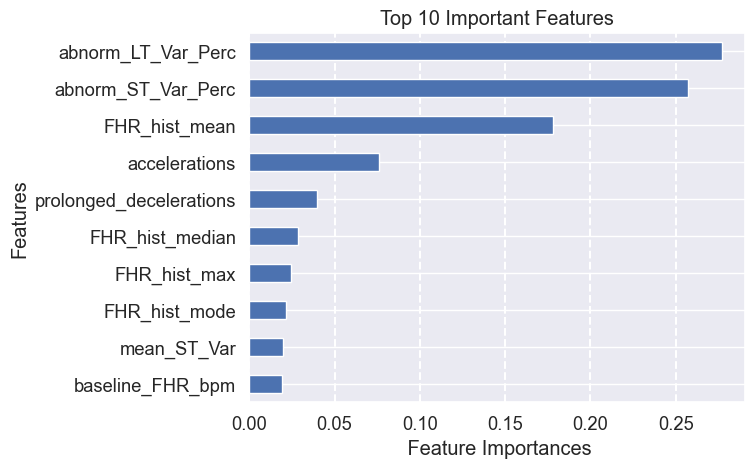

In [43]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(best_gb_model.feature_importances_, data.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: "Feature Importances"}, inplace=True)
importances_sorted = importances_df.sort_values(by="Feature Importances")

# Selecting only the top 10 important features
top_10_importances = importances_sorted.tail(10)

# Plotting the top 10 important features
top_10_importances.plot(kind="barh",title="Top 10 Important Features", legend=False)
plt.xlabel(" Feature Importances")
plt.ylabel("Features")
# Adding grid lines
plt.grid(True, axis="x", linestyle="--", linewidth=1.5)
plt.show()

## KNN Classifier 


In [44]:
# Create a KNN classifier 
knn = KNeighborsClassifier()

In [45]:
# Define the hyperparameter grid for grid search
param_grid = {
    'n_neighbors': [2,3, 5, 7, 9],  # Adjust the number of neighbors
    'weights': ['uniform', 'distance'],  # Adjust the weight function ('uniform' or 'distance')
   
}


In [46]:
# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_ros, y_train_ros)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [47]:
# Get the best hyperparameters found by grid search
best_params = grid_search.best_params_
best_params

{'n_neighbors': 2, 'weights': 'distance'}

In [48]:
# Train the classifier on the training data
#knn.fit(X_train_ros, y_train_ros)



In [49]:

# Create a new KNN classifier with the best hyperparameters
best_knn = KNeighborsClassifier(**best_params)

In [50]:
# Train the classifier with the best hyperparameters
best_knn.fit(X_train_ros, y_train_ros)

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [51]:
# Make predictions on the testing data
predictions_knn= best_knn.predict(X_test_ros)

In [52]:
# Calculate the accuracy of the model
accuracy_knn = accuracy_score(y_test_ros,predictions_knn)
print("Accuracy_Knn:", accuracy_knn)

Accuracy_Knn: 0.9785867237687366


In [53]:
# Generate a confusion matrix
cm = confusion_matrix(y_test_ros, predictions_knn)
print("Confusion Matrix:")
cm_df=pd.DataFrame(cm,index=["Normal","Suspect","pathology"],columns=["Normal","Suspect","pathology"])
print("KNN Classifier")
cm_df

Confusion Matrix:
KNN Classifier


,Normal,Suspect,pathology
Normal,303,20,0
Suspect,0,313,0
pathology,0,0,298


In [54]:
# Generate a classification report
print("KNN Classification Report :")
knn_report=classification_report(y_test_ros, predictions_knn)
print(knn_report)

KNN Classification Report :
              precision    recall  f1-score   support

           1       1.00      0.94      0.97       323
           2       0.94      1.00      0.97       313
           3       1.00      1.00      1.00       298

    accuracy                           0.98       934
   macro avg       0.98      0.98      0.98       934
weighted avg       0.98      0.98      0.98       934



## Support Vector Machine Algorithm

In [55]:

scaler = StandardScaler()

X_scaler = scaler.fit(X_train_ros)

X_train_scaled = X_scaler.transform(X_train_ros)
X_test_scaled = X_scaler.transform(X_test_ros)

In [56]:
# Define the SVM classifier
svm = SVC(random_state=48)

In [57]:


# Define the hyperparameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient (for 'rbf' and 'poly' kernels)
}


# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_ros)

# Get the best hyperparameters found by grid search
best_params = grid_search.best_params_





In [58]:
# Create a new SVM classifier with the best hyperparameters
best_svm = SVC(**best_params)
best_svm 

SVC(C=10, kernel='poly')

In [59]:

# Train the classifier with the best hyperparameters and scaled data
best_svm.fit(X_train_scaled, y_train_ros)

SVC(C=10, kernel='poly')

In [60]:
# Make predictions on the scaled test data
predictions_svm = best_svm.predict(X_test_scaled)

In [61]:
# Calculate the accuracy of the model
accuracy_svm = accuracy_score(y_test_ros, predictions_svm)
print("Accuracy_svm:", accuracy_svm)

Accuracy_svm: 0.9635974304068522


In [62]:
# Make predicitions
predictions = best_svm.predict(X_test_scaled)
predictions_formatted = [f'{pred:.1f}' for pred in predictions]
predictions_formatted

['3.0',
 '2.0',
 '1.0',
 '2.0',
 '3.0',
 '3.0',
 '2.0',
 '3.0',
 '1.0',
 '1.0',
 '1.0',
 '1.0',
 '2.0',
 '2.0',
 '2.0',
 '2.0',
 '3.0',
 '2.0',
 '3.0',
 '1.0',
 '3.0',
 '3.0',
 '3.0',
 '1.0',
 '2.0',
 '1.0',
 '3.0',
 '2.0',
 '2.0',
 '1.0',
 '2.0',
 '3.0',
 '3.0',
 '1.0',
 '1.0',
 '1.0',
 '1.0',
 '2.0',
 '1.0',
 '1.0',
 '2.0',
 '3.0',
 '3.0',
 '1.0',
 '3.0',
 '2.0',
 '3.0',
 '3.0',
 '1.0',
 '2.0',
 '2.0',
 '1.0',
 '3.0',
 '3.0',
 '1.0',
 '1.0',
 '1.0',
 '3.0',
 '1.0',
 '3.0',
 '2.0',
 '3.0',
 '2.0',
 '1.0',
 '2.0',
 '1.0',
 '3.0',
 '2.0',
 '2.0',
 '1.0',
 '3.0',
 '1.0',
 '2.0',
 '2.0',
 '3.0',
 '1.0',
 '1.0',
 '3.0',
 '2.0',
 '3.0',
 '3.0',
 '3.0',
 '3.0',
 '1.0',
 '3.0',
 '2.0',
 '1.0',
 '2.0',
 '1.0',
 '2.0',
 '1.0',
 '1.0',
 '1.0',
 '1.0',
 '2.0',
 '1.0',
 '1.0',
 '2.0',
 '3.0',
 '2.0',
 '2.0',
 '1.0',
 '2.0',
 '2.0',
 '2.0',
 '1.0',
 '2.0',
 '3.0',
 '2.0',
 '2.0',
 '1.0',
 '1.0',
 '2.0',
 '2.0',
 '1.0',
 '3.0',
 '3.0',
 '2.0',
 '1.0',
 '1.0',
 '1.0',
 '2.0',
 '2.0',
 '3.0',
 '1.0',


In [63]:
# Print classification report

svm_report = classification_report(y_test_ros, predictions_svm)
print(svm_report)

              precision    recall  f1-score   support

           1       0.99      0.91      0.95       323
           2       0.91      0.99      0.95       313
           3       1.00      0.99      0.99       298

    accuracy                           0.96       934
   macro avg       0.97      0.96      0.96       934
weighted avg       0.97      0.96      0.96       934



In [64]:


cm = confusion_matrix(y_test_ros, predictions_svm)
cm_df = pd.DataFrame(
    cm,
   index=["Normal","Suspect","pathology"],
    columns=["Normal","Suspect","pathology"]
)


cm_df

,Normal,Suspect,pathology
Normal,295,27,1
Suspect,3,310,0
pathology,0,3,295


In [65]:


accuracy = accuracy_score(y_test_ros, predictions_svm)
print(f"Accuracy score: {round((accuracy), 2)}")

precision = precision_score(y_test_ros, predictions_svm, average = 'macro')
print(f"Precision score: {round((precision), 2)}")

Accuracy score: 0.96
Precision score: 0.97


## Neural Network Model

In [66]:
# Scale X data


scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [67]:
# Find input dimensions
input_dim = len(fetal_df.columns) - 1

In [68]:
# Define the deep learning model 
nn = tf.keras.models.Sequential()

nn.add(tf.keras.layers.Dense(units = 128, activation = 'relu', input_dim = input_dim))

nn.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))


nn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

# Check model summary
nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Compile the Sequential model together and customize metrics
nn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Train the model
model_fit = nn.fit(X_train_scaled, y_train, epochs =500,batch_size=32)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose = 2)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7410 - loss: 0.0000e+00
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7622 - loss: 0.0000e+00
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7846 - loss: 0.0000e+00
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7742 - loss: 0.0000e+00
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7784 - loss: 0.0000e+00
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.0000e+00
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7862 - loss: 0.0000e+00
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7945 - loss: 0.0000e+00
Epoch 9/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7872 - loss: 0.0000e+00
Epoch 10/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7771 - loss: 0.0000e+00
Epoch 11/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7753 - loss: 0.0000e+00
Epoch 12/500
50/50 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7808 - loss: 0.0000e+00
Epoch 68/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7889 - loss: 0.0000e+00
Epoch 69/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.7790 - loss: 0.0000e+00
Epoch 70/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7809 - loss: 0.0000e+00 
Epoch 71/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7889 - loss: 0.0000e+00
Epoch 72/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.7714 - loss: 0.0000e+00
Epoch 73/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.7870 - loss: 0.0000e+00
Epoch 74/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7918 - loss: 0.0000e+00
Epoch 75/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7902 - loss: 0.0000e+00
Epoch 76/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7904 - loss: 0.0000e+00 
Epoch 77/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7811 - loss: 0.0000e+00 
Epoch 78/500

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7904 - loss: 0.0000e+00 
Epoch 198/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7791 - loss: 0.0000e+00 
Epoch 199/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7837 - loss: 0.0000e+00
Epoch 200/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7656 - loss: 0.0000e+00
Epoch 201/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7835 - loss: 0.0000e+00 
Epoch 202/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7804 - loss: 0.0000e+00
Epoch 203/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7780 - loss: 0.0000e+00
Epoch 204/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7924 - loss: 0.0000e+00
Epoch 205/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.7752 - loss: 0.0000e+00
Epoch 206/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7687 - loss: 0.0000e+00
Epoch 207/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.7952 - loss: 0.0000e+00
Epoch 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.7890 - loss: 0.0000e+00
Epoch 328/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7792 - loss: 0.0000e+00
Epoch 329/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7892 - loss: 0.0000e+00 
Epoch 330/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7865 - loss: 0.0000e+00
Epoch 331/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7664 - loss: 0.0000e+00
Epoch 332/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7971 - loss: 0.0000e+00
Epoch 333/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7941 - loss: 0.0000e+00
Epoch 334/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7690 - loss: 0.0000e+00
Epoch 335/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7852 - loss: 0.0000e+00
Epoch 336/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7755 - loss: 0.0000e+00
Epoch 337/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7899 - loss: 0.0000e+00
Epoch 33

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7845 - loss: 0.0000e+00
Epoch 393/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.7725 - loss: 0.0000e+00
Epoch 394/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.7850 - loss: 0.0000e+00
Epoch 395/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.7987 - loss: 0.0000e+00
Epoch 396/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7825 - loss: 0.0000e+00
Epoch 397/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8071 - loss: 0.0000e+00
Epoch 398/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.7854 - loss: 0.0000e+00
Epoch 399/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7775 - loss: 0.0000e+00
Epoch 400/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.7728 - loss: 0.0000e+00
Epoch 401/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7866 - loss: 0.0000e+00 
Epoch 402/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.7793 - loss: 0.0000e+0

Epoch 457/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7750 - loss: 0.0000e+00
Epoch 458/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7847 - loss: 0.0000e+00
Epoch 459/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7764 - loss: 0.0000e+00
Epoch 460/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7781 - loss: 0.0000e+00
Epoch 461/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7822 - loss: 0.0000e+00
Epoch 462/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.7675 - loss: 0.0000e+00
Epoch 463/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7891 - loss: 0.0000e+00 
Epoch 464/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.7700 - loss: 0.0000e+00
Epoch 465/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.7847 - loss: 0.0000e+00
Epoch 466/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7763 - loss: 0.0000e+00
Epoch 467/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7718 - loss: 0.0

In [70]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

17/17 - 0s - 2ms/step - accuracy: 0.7707 - loss: 0.0000e+00
Loss: 0.0, Accuracy: 0.7706766724586487


##  Decision Tree

In [71]:
# instantiating and fitting decision tree model
dt = DecisionTreeClassifier(criterion='gini', random_state=48) 
#dt.fit(X_train_ros, y_train_ros)

In [72]:
# Define the hyperparameters grid
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


In [73]:
# Fit the grid search to the data
grid_search_dt.fit(X_train_ros, y_train_ros)  # Assuming you have X_train and y_train

# Get the best parameters and the best model
best_dt_params = grid_search_dt.best_params_
best_dt_model = grid_search_dt.best_estimator_
print("Best Parameters:", best_dt_params)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [74]:
#predict the model
#predictions_dt = dt.predict(X_test_ros)
predictions_dt = best_dt_model.predict(X_test_ros)


In [75]:
# confusion matrix 

cm = confusion_matrix(y_test_ros, predictions_dt)
print("Confusion Matrix:")
cm_df=pd.DataFrame(cm,index=["Normal","Suspect","pathology"],columns=["Normal","Suspect","pathology"])
print("Decision Tree")
cm_df


Confusion Matrix:
Decision Tree


,Normal,Suspect,pathology
Normal,297,21,5
Suspect,1,312,0
pathology,0,0,298


In [76]:

# Generate a classification report
print("Decision Tree Classification Report :")
dt_report=classification_report(y_test_ros, predictions_dt)
print(dt_report)

Decision Tree Classification Report :
              precision    recall  f1-score   support

           1       1.00      0.92      0.96       323
           2       0.94      1.00      0.97       313
           3       0.98      1.00      0.99       298

    accuracy                           0.97       934
   macro avg       0.97      0.97      0.97       934
weighted avg       0.97      0.97      0.97       934



In [77]:
# Calculate the accuracy of the model
accuracy_dt = accuracy_score(y_test_ros,predictions_dt)
print("Accuracy_dt:", accuracy_dt)

Accuracy_dt: 0.9710920770877944


In [78]:

# Assuming you have accuracy scores for Random Forest, Gradient Boosting, K-Nearest Neighbors, Support Vector Machine, and TensorFlow
accuracy_scores = {
    "Model": ["Random Forest", "Gradient Boosting", "K-Nearest Neighbors", "Support Vector Machine", "TensorFlow","Decision Tree"],
    "Accuracy": [accuracy_rf, accuracy_gb, accuracy_knn, accuracy_svm, model_accuracy,accuracy_dt]  
}

# Create DataFrame
accuracy_df = pd.DataFrame(accuracy_scores)

# Display DataFrame
print(accuracy_df)


                    Model  Accuracy
0           Random Forest  0.985011
1       Gradient Boosting  0.993576
2     K-Nearest Neighbors  0.978587
3  Support Vector Machine  0.963597
4              TensorFlow  0.770677
5           Decision Tree  0.971092
